# Deutsch's Algorithm: A Query Model Introduction

Deutsch's Algorithm is a fundamental proof-of-concept in quantum computing. It was the first algorithm to demonstrate a distinct quantum advantage over classical computers.



## The Problem: Constant or Balanced?

We have a "Black Box" (Oracle) that computes a 1-bit function $f:\{0,1\} \rightarrow \{0,1\}$. The function is guaranteed to be one of two types:
* **Constant:** Returns the same output for all inputs (0 or 1)
* **Balanced:** Returns 0 for half the inputs and 1 for the other half.

**Goal:** Determine if $f$ is *Constant* or *Balanced* using the minimum number of queries.

<div style="background-color: #f7f7f7; border: 1px solid #ccc; padding: 15px; border-radius: 5px; margin-bottom: 15px;">
  <h4 style="margin-top:0;">Deutsch's Problem</h4>
  <ul>
    <li><b>Input:</b> A function $f : \{0,1\}\rightarrow \{0,1\}$</li>
    <li><b>Output:</b> 0 if $f$ is constant, 1 if $f$ is balanced</li>
  </ul>
</div>


There are only four possible functions that fit this description, and they are categorized into two types:
* **Constant:** The output is the same regardless of the input.
    * $f(0) = 0$ and $f(1) = 0$
    * $f(0) = 1$ and $f(1) = 1$
* **Balanced:** The output is 0 or half the inputs and 1 for the other half
    * $f(0) = 0$ and $f(1) = 1$ (Identity)
    * $f(0) = 1$ and $f(1) = 0$ (Bit flip)

The input function to Deutsch's problem can be gven as 4 different functions:
$$
\begin{array}{c c}
    \text{function} & \text{string} & \text{result} \\ \hline
    f_1 & 00 & \text{constant} \\
    f_2 & 01 & \text{balanced} \\
    f_3 & 10 & \text{balanced} \\
    f_4 & 11 & \text{constant}
\end{array}
$$

# 1. Imports and Configuration

In [1]:
from qiskit import QuantumCircuit, __version__
from qiskit_aer import AerSimulator
from qiskit.circuit import Gate
print(__version__)

2.2.1


# 2. Function Setup - The Oracle (Black Box)

**Deutsch's** can be setup with two qubits:
* Qubit 0 = the input $x$
* Qubit 1 = the output $y$

Then the oracle must implement:
$$U_f:\ket{x,y} \rightarrow \ket{x,y \oplus f(x)}$$

This leads to four different possible cases:
* **case 1** - Do nothing: $\ket{x,y} \rightarrow \ket{x,y} = 0$
* **case 2** - CX:         $\ket{x,y} \rightarrow \ket{x,y \oplus x} = x$
* **case 3** - CX then X:  $\ket{x,y} \rightarrow \ket{x,y\oplus x \oplus 1} = x \oplus 1$
* **case 4** - X:          $\ket{x,y} \rightarrow \ket{x,y\oplus 1} = 1$

### Example Oracle
This circuit just shows where the oracle fits in terms of the quantum circuit.  
As we actually build the circuit, it will be replaced by quantum gates, depending on which function is selected.  

The following circuit is an example. The $U_f$ gate will be replaced with the actual oracle, depending on the function

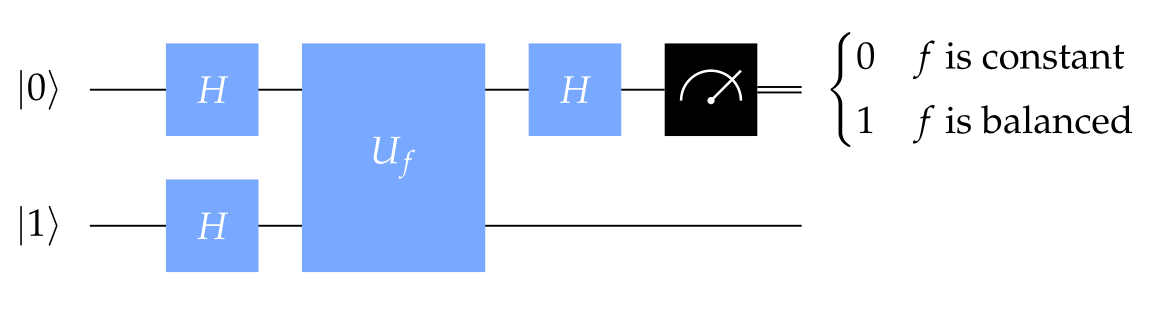

**Notice: Deutsch needs initialized**  
$$q_0 = \ket{0} \quad q_1 = \ket{1}$$
In the actual circuit, this is done by applying a NOT gate to $q_1$ before the Hadamard operations

**Create the Deutsch Function**


In [23]:
def deutsch_function(case: int):
    """
    Generate a quantum circuit for one of the 4 functions.
    From one bit to one bit
    """
    if case not in [1,2,3,4]:
        raise ValueError("'case' must be 1, 2, 3, or 4")

    f = QuantumCircuit(2)
    # Case 1: nothing
    # Case 2: CNOT
    # Case 3: CNOT, X
    # Case 4: X
    if case in [2, 3]:
        f.cx(0,1)
    if case in [3,4 ]:
        f.x(1)
    return f

**Display the circuit for one of the functions**

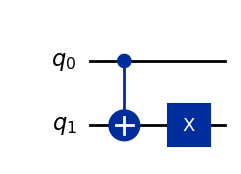

In [5]:
display(deutsch_function(3).draw(output='mpl'))

In [6]:
display(deutsch_function(3).draw())

q_0: ──■───────
     ┌─┴─┐┌───┐
q_1: ┤ X ├┤ X ├
     └───┘└───┘

# 3. Complete the Circuit

Now we create the actual quantum circuit for Deutsch's Algorithm, substituting the query gate (oracle) with a quantum circuit implementation as an argument.
$$\ket{x,y} \rightarrow \ket{x,y \oplus f(x)}$$

In [7]:
def compile_circuit(function: QuantumCircuit):
    """
    Compiles a circuit for use in Deutsch's algorithm
    """
    n = function.num_qubits -1

    # Create a new quantum circuit with (n inputs + 1 output) qubits, and n classical bits
    qc = QuantumCircuit(n + 1, n)

    # Apply X gate to the output qubit
    qc.x(n)

    # Apply Hadamard to all qubits (inputs and outputs)
    qc.h(range(n+1))

    # Adds a visual barrier in the diagram
    qc.barrier()

    # Compose appends another circuit to this circuit.
    # In this case, we will be appending the deutsch_function
    qc.compose(function, inplace=True)
    qc.barrier()

    # Apply Hadamard to input qubit
    qc.h(range(n))

    # Measure the input qubits onto the corresponding classical bits
    # If all measured bits are 0, the function is constante
    # if any bit is 1, the function is balanced
    qc.measure(range(n), range(n))

    return qc

**Display the Circuit**

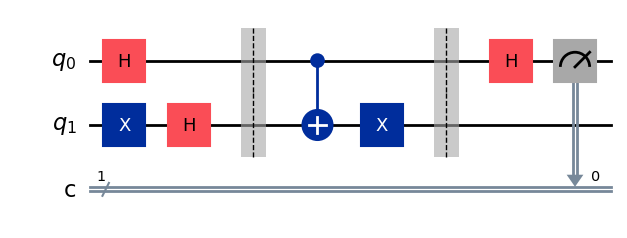

In [8]:
display(compile_circuit(deutsch_function(3)).draw(output="mpl"))

In [9]:
display(compile_circuit(deutsch_function(3)).draw())

┌───┐      ░            ░ ┌───┐┌─┐
q_0: ┤ H ├──────░───■────────░─┤ H ├┤M├
     ├───┤┌───┐ ░ ┌─┴─┐┌───┐ ░ └───┘└╥┘
q_1: ┤ X ├┤ H ├─░─┤ X ├┤ X ├─░───────╫─
     └───┘└───┘ ░ └───┘└───┘ ░       ║ 
c: 1/════════════════════════════════╩═
                                     0

# 4. Deutsch's Algorithm

This section runs the complete algorithm on a quantum simulator. We use Qiskit's Aer Simulator

In [10]:
def deutsch_algorithm(function: QuantumCircuit):
    """
    Determine if a one-bit function is constant or balanced
    """
    qc = compile_circuit(function)

    # Run complete circuit on Aer Simulator and get results
    result = AerSimulator().run(qc, shots=1, memory=True).result()
    measurements = result.get_memory()

    # Analyze answer
    if measurements[0] == "0":
        return "constant"
    return "balanced"

In [11]:
f = deutsch_function(3)
display(deutsch_algorithm(f))

'balanced'

# 5. Results

Display the results for all four of the bit-to-bit functions

'f(1) = constant'

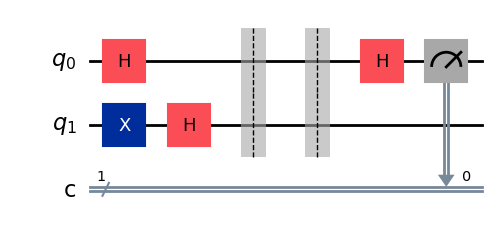

'f(2) = balanced'

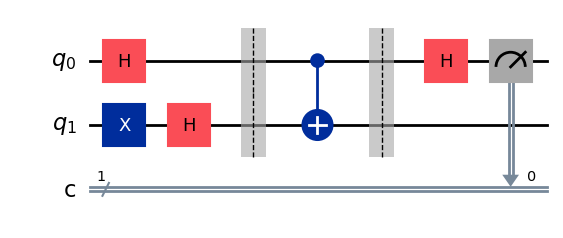

'f(3) = balanced'

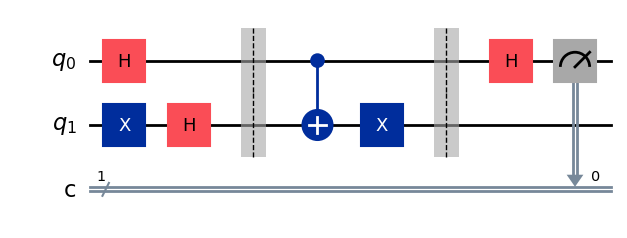

'f(4) = constant'

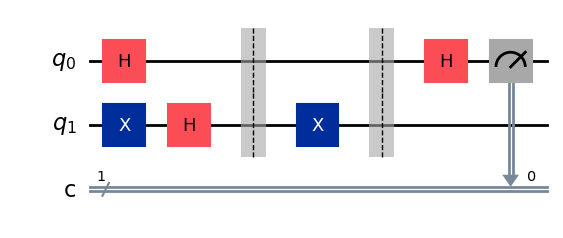

In [12]:
for i in range (1, 5):
    f = deutsch_function(i)
    display(f"f({i}) = {deutsch_algorithm(f)}")
    display(compile_circuit(f).draw(output="mpl"))
